In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.distributions as D
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import random
import copy
import math
import os
import argparse
from functools import partial
from torch.nn import Sequential as Sq


In [2]:
train_transform = transforms.Compose([transforms.RandomHorizontalFlip(), transforms.ToTensor()])
test_transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.CIFAR10(root='../data', train=True, download=True, transform=train_transform)
test_dataset = datasets.CIFAR10(root='../data', train=False, download=True, transform=test_transform)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
def img_norm(img):
    return 2 * img - 1

def to_img(img):
    return 0.5 * img + 0.5


def update_ema(ema_model, model, ema_rate):
    for tar, src in zip(ema_model.parameters(), model.parameters()):
        tar.data.mul_(ema_rate).add_(src.data * (1 - ema_rate))


class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.avg = 0
        self.sum = 0
        self.cnt = 0

    def update(self, val, n=1):
        self.sum += val * n
        self.cnt += n
        self.avg = self.sum / self.cnt

In [4]:
class PositionalEmbedding(nn.Module):
    def __init__(self, embed_dim, max_positions=10000):
        super().__init__()
        self.embed_dim = embed_dim
        self.max_positions = max_positions 
        self.half_dim = embed_dim // 2
        self.emb = math.log(max_positions) / (self.half_dim - 1)
        self.emb = torch.exp(torch.arange(self.half_dim).float() * -self.emb)
        # self.emb = nn.Parameter(self.emb, requires_grad=False)
        self.register_buffer('proj', self.emb)
        self.pad = nn.Identity() if embed_dim % 2 == 0 else nn.ConstantPad1d((0, 1), value=0.)

    def forward(self, t):
        assert torch.max(t) <= 1.0 and torch.min(t) >= 0.0
        t = 0.1 * self.max_positions * t[:, None] * self.proj[None, :]
        return self.pad(torch.cat([torch.sin(t), torch.cos(t)], dim=-1))



In [5]:
class Base2FourierFeatures(nn.Module):
    def __init__(self, n_min=6, n_max=7):
        super().__init__()
        self.freq = torch.arange(n_min, n_max + 1)
        self.w = (2. ** self.freq) * 2 * torch.pi
        self.w = self.w.unflatten(0, (-1, 1, 1, 1))
        self.register_buffer('proj', self.w)

    def forward(self, x):
        x = (x.unsqueeze(1) * self.proj).flatten(1, 2)
        x = torch.cat([torch.sin(x), torch.cos(x)], dim=1)
        return x

In [6]:
class Conv2d(nn.Conv2d):
    def __init__(self, cin, cout, kernel_size=3, stride=1, padding="same", dilation=1, groups=1, bias=True, init_scale=1.):
        super().__init__(cin, cout, kernel_size, stride, padding, dilation, groups, bias)
        self.init_scale = init_scale
        self.weight.data *= self.init_scale
        
    def reset_parameters(self):
        bound = 1./ np.sqrt(np.prod(self.weight.data.size()[1:]))
        nn.init.uniform_(self.weight.data, -bound, bound)
        if self.bias is not None:
            nn.init.zeros_(self.bias.data)
    

In [7]:
class ResBlock(nn.Module):
    def __init__(self, in_ch, out_ch, t_dim=None, dor=0.05, bnr=0.5):
        super().__init__()
        mid_ch = int(bnr * in_ch)
        self.conv1 = Sq(nn.GroupNorm(16, in_ch),
                        nn.SiLU(inplace=True),
                        Conv2d(in_ch, mid_ch, 3))
        self.time = Conv2d(t_dim, mid_ch, 1, init_scale=0.) if t_dim is not None else None
        self.conv2 = Sq(nn.GroupNorm(16, mid_ch),
                        nn.SiLU(inplace=True),
                        nn.Dropout(p=dor),
                        Conv2d(mid_ch, out_ch, 3, init_scale=0.))
        self.skip = nn.Identity() if in_ch == out_ch else nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x, t=None):
        h = self.conv1(x)
        if t is not None:
            h = h + self.time(t)
        h = self.conv2(h)
        return h + self.skip(x)



In [8]:
class AttnBlock(nn.Module):
    def __init__(self, ch, num_heads=4, bnr=0.5):
        super().__init__()
        self.mid_ch = int(bnr * ch)
        self.ch, self.num_heads = ch, num_heads
        self.norm = nn.GroupNorm(16, self.ch)
        self.proj = Conv2d(ch, 3 * self.mid_ch, 1, bias=False)
        self.out = Conv2d(self.mid_ch, ch, 1, init_scale=0.)
        self.scale = (self.mid_ch // self.num_heads) ** -0.5

    def forward(self, x):
        h = self.norm(x)
        q, k, v = self.proj(h).flatten(-2, -1).unflatten(1, (self.num_heads * 3, -1)).chunk(3, dim=1)
        w = torch.matmul(q.transpose(-2, -1), k * self.scale)
        h = torch.matmul(v, w.softmax(dim=-2)).unflatten(-1, x.size()[2:]).flatten(1, 2)
        h = self.out(h)
        return x + h

In [9]:
class Blur(nn.Module):
    def __init__(self, kernel=[1, 2, 1], normalize=True, replication_pad=False):
        super().__init__()
        kernel = torch.FloatTensor(kernel)
        kernel = kernel[None, None, :] * kernel [None, :, None]
        if normalize:
            kernel = kernel / kernel.sum()

        self.register_buffer('kernel', kernel)

        pad = (self.kernel.size()[-1] - 1) // 2

        if self.kernel.size()[-1] % 2 == 1:
            pad = (pad, pad, pad, pad)
        else:
            pad = (pad, pad + 1, pad, pad + 1)

        if replication_pad:
            self.pad = nn.ReflectionPad2d(pad)
        else:
            self.pad = nn.ZeroPad2d(pad)



    def forward(self, x):

        kernel = self.kernel.expand(x.size(1), -1, -1, -1)
        x = F.conv2d(self.pad(x), kernel, stride=1, padding=0, groups=x.size(1))
        return x



In [10]:
class Downsample(nn.Module):
    def __init__(self, stride=2):

    # def __init__(self, stride=2, lpf=[1, 3, 3, 1]):
        super().__init__()
        # self.blur = nn.Identity() if lpf is None else Blur(lpf)
        self.stride = stride

    def forward(self, x):
        # x = F.avg_pool2d(self.blur(x), self.stride)
        x = F.interpolate(x, scale_factor=1./self.stride, mode='bilinear', align_corners=False)
        
        return x


class Upsample(nn.Module):
    def __init__(self, stride=2):
        super().__init__()
        self.stride = stride

    def forward(self, x):
        x = F.interpolate(x, scale_factor=self.stride, mode='bilinear', align_corners=False)
        return x


In [11]:
def normal_cdf(x, loc, std):
    return 0.5 * (1 + torch.erf((x - loc) / (std * math.sqrt(2))))

def pixel_log_prob(x, loc, std, num_bits=8):
    assert -1. <= torch.min(x) and torch.max(x) <= 1.
    
    max_val = 2. ** num_bits - 1
    half_size = 1. / max_val

    rcdf = normal_cdf(x + half_size, loc, std)
    lcdf = normal_cdf(x - half_size, loc, std)
    log_quantized_prob = torch.log(rcdf - lcdf)
    log_quantized_prob0 = torch.log(rcdf)
    log_quantized_prob255 = torch.log(1. - lcdf)
    log_quantized_prob = torch.where(x > 0.999, log_quantized_prob255,
                                        torch.where(x < -0.999, log_quantized_prob0, 
                                                    log_quantized_prob))
    return log_quantized_prob


def sn_coeff(log_snr):
    alp = log_snr.sigmoid().sqrt()
    std = log_snr.neg().sigmoid().sqrt()
    return alp, std

def forward_sn_coeff(alp_s, std_s, alp_t, std_t): # 0 <= s < t <= 1
    falp_t = alp_t / alp_s  # q(t|s)
    fstd_t = (std_t.square() - std_s.square() * falp_t.square()).sqrt()
    return falp_t, fstd_t

def reverse_sn_coeff(alp_s, std_s, alp_t, std_t):        # q(z_s|z_t, z_0)
    falp_t, fstd_t = forward_sn_coeff(alp_s, std_s, alp_t, std_t)
    rstd_s = std_s * fstd_t / std_t
    ralp_0 = rstd_s.square() * alp_s / std_s.square()    # for z0(= signal)
    ralp_t = rstd_s.square() * falp_t / fstd_t.square()  # for zt(= noise at time t)
    return ralp_0, ralp_t, rstd_s


class LogLinearSnrDiffuser(nn.Module):
    def __init__(self):
        super().__init__()
        base = torch.tensor([1e-4]).double()
        lsnr0 = base.expm1().log().neg().float()
        lsnr1 = base.add(10).exp().add(-1).log().neg().float()
        self.register_buffer('base', base)
        self.register_buffer('lsnr0', lsnr0)
        self.register_buffer('lsnr1', lsnr1)

    def sample_time(self, batch_size):
        return torch.rand(batch_size)

    def log_snr(self, t):
        return self.lsnr0 + (self.lsnr1 - self.lsnr0) * t
    
    def __call__(self, x, t, epst=None):
        epst = torch.randn_like(x) if epst is None else epst
        log_snr = self.log_snr(t).unflatten(-1, (-1, *[1 for _ in x.size()[1:]]))
        alp, std = sn_coeff(log_snr)
        return alp * x + std * epst, epst

    @torch.no_grad()
    def reverse_process(self, z, model, num_steps):
        time = torch.ones(z.size()[0]).to(z.device)
        reversed_time = torch.linspace(1., 0., num_steps + 1)
        dt = reversed_time[0] - reversed_time[1]
        for i in range(num_steps): # t -> s
            t = reversed_time[i]        
            s = reversed_time[i + 1]
            lnsr_s = self.log_snr(s)
            lnsr_t = self.log_snr(t)
            alp_s, std_s = sn_coeff(lnsr_s)
            alp_t, std_t = sn_coeff(lnsr_t)
            ralp_0, ralp_t, rstd_s = reverse_sn_coeff(alp_s, std_s, alp_t, std_t)
            time.fill_(t)
            eps_pred = model(z, time)
            z0_pred = (z - std_t * eps_pred) / alp_t
            rloc_s = ralp_0 * z0_pred + ralp_t * z
            z = rloc_s + torch.randn_like(z) * rstd_s
        return z, z0_pred

    @torch.no_grad()
    def evaluate(self, x, model, num_steps):
        time = torch.ones(z.size()[0]).to(z.device)
        reversed_time = torch.linspace(1., 0., num_steps + 1)
        dt = reversed_time[0] - reversed_time[1]

        elbo = 0.
        for i in range(num_steps): # t -> s
            t = reversed_time[i]        
            s = reversed_time[i + 1]
            lnsr_s = self.log_snr(s)
            lnsr_t = self.log_snr(t)
            alp_s, std_s = sn_coeff(lnsr_s)
            alp_t, std_t = sn_coeff(lnsr_t)
            ralp_0, ralp_t, rstd_s = reverse_sn_coeff(alp_s, std_s, alp_t, std_t)
            time.fill_(t)
            eps_pred = model(z, time)
            z0_pred = (z - std_t * eps_pred) / alp_t
            rloc_s = ralp_0 * x + ralp_t * z


            if i != num_steps - 1:
                kld = 0.5 * (ralp_0 * (x - z0_pred) / rstd_s).square().mean(dim=0).sum()
                elbo = elbo - kld
            else:

                log_prob = pixel_log_prob(x, ralp_0 * z0_pred + ralp_t * z, rstd_s).mean(dim=0).sum()
                elbo = elbo + log_prob
            
            
            z = rloc_s + torch.randn_like(z) * rstd_s
        
        bpd = elbo / (np.prod(x.size()[1:]) * np.log(2))
        return bpd


In [12]:
class UNet(nn.Module):
    def __init__(self, args):
        super().__init__()
        self.img_ch  = args.img_ch
        self.main_ch = args.arch.main_ch
        self.n_layer = args.arch.n_layer 
        self.t_dim   = args.arch.t_dim
        self.ch_mult = args.arch.ch_mult
        self.use_attn = args.arch.use_attn

        self.chs = [self.main_ch * ch_mul for ch_mul in self.ch_mult]
        self.base_ch = self.chs[-1]
        
        self.use_pixel_fourier = args.arch.use_pixel_fourier

        self.stride = args.arch.stride
        self.num_levels = len(self.chs)

        if self.use_pixel_fourier:
            n_min, n_max = 6, 7
            self.pixel_fourier = Base2FourierFeatures(n_min=n_min, n_max=n_max)
            in_ch = (n_max + 1 - n_min) * self.img_ch * 2 + self.img_ch
        
        else:
            in_ch = self.img_ch

        self.from_rgb = Sq(Conv2d(in_ch, self.main_ch, 3),
                           nn.GroupNorm(16, self.main_ch), nn.SiLU(inplace=True),
                           Conv2d(self.main_ch, self.main_ch, 3))
        
        self.from_time = Sq(PositionalEmbedding(self.main_ch),
                            nn.Unflatten(-1, (-1, 1, 1)),
                            Conv2d(self.main_ch, self.t_dim, 1), 
                            nn.SiLU(inplace=True),
                            Conv2d(self.t_dim,   self.t_dim, 1), 
                            nn.SiLU())

        self.down     = []
        self.enc      = []
        self.enc_attn = []
        for l, n in enumerate(self.n_layer):
            in_ch = self.chs[l - 1] if l != 0 else self.main_ch
            out_ch = self.chs[l]
            stride = self.stride[l]
            use_attn = self.use_attn[l]
            down = nn.Identity() if stride == 1 else Downsample(stride)
            enc = [ResBlock(in_ch, out_ch, self.t_dim)]
            enc += [ResBlock(out_ch, out_ch, self.t_dim) for j in range(1, n)]
            enc = nn.ModuleList(enc)
            
            enc_attn = nn.ModuleList([AttnBlock(out_ch, num_heads=4) for j in range(n)]) if use_attn else None
            
            self.down += [down]
            self.enc  += [enc]
            self.enc_attn += [enc_attn]

        self.down     = nn.ModuleList(self.down)
        self.enc      = nn.ModuleList(self.enc)
        self.enc_attn = nn.ModuleList(self.enc_attn)

        self.mid_enc = ResBlock(self.base_ch, self.base_ch, t_dim=self.t_dim)
        self.mid_attn = AttnBlock(self.base_ch, num_heads=1)
        self.mid_dec = ResBlock(self.base_ch, self.base_ch, t_dim=self.t_dim)

        self.up       = []
        self.dec      = []
        self.dec_attn = []

        for l, n in enumerate(self.n_layer):
            in_ch = self.chs[l]
            out_ch = self.chs[l - 1] if l != 0 else self.main_ch
            stride = self.stride[l]
            use_attn = self.use_attn[l]

            dec_attn = nn.ModuleList([AttnBlock(in_ch, num_heads=4) for j in range(n)]) if use_attn else None
            dec = [ResBlock(2 * in_ch, in_ch, self.t_dim) for j in range(n - 1)]
            dec += [ResBlock(2 * in_ch, out_ch, self.t_dim)]
            dec = nn.ModuleList(dec)
            
            up = nn.Identity() if stride == 1 else Upsample(stride)
            self.dec_attn += [dec_attn]
            self.dec += [dec]
            self.up += [up]

        self.dec_attn = nn.ModuleList(self.dec_attn)
        self.dec      = nn.ModuleList(self.dec)
        self.up       = nn.ModuleList(self.up)

        self.to_rgb = Sq(nn.GroupNorm(16, self.main_ch), nn.SiLU(inplace=True),
                         Conv2d(self.main_ch, self.main_ch, 3),
                         nn.GroupNorm(16, self.main_ch), nn.SiLU(inplace=True),
                         Conv2d(self.main_ch, self.img_ch, 3, init_scale=0.))
        
    def forward(self, x, t):
        x_org = x
        if self.use_pixel_fourier:
            x = torch.cat([x, self.pixel_fourier(x)], 1)
        x, t = self.from_rgb(x), self.from_time(t)

        skip = []

        for i in range(self.num_levels):
            x = self.down[i](x)
            for j in range(self.n_layer[i]):
                x = self.enc[i][j](x, t)
                skip += [x]
                if self.enc_attn[i] is not None:
                    x = self.enc_attn[i][j](x)
        
        x = self.mid_enc(x, t)
        x = self.mid_attn(x)
        x = self.mid_dec(x, t)

        for i in range(self.num_levels)[::-1]:
            for j in range(self.n_layer[i]):
                if self.dec_attn[i] is not None:
                    x = self.dec_attn[i][j](x)
                x = self.dec[i][j](torch.cat([x, skip.pop()], 1), t)
            x = self.up[i](x)
        x = self.to_rgb(x)
        return x


In [13]:
args = argparse.Namespace()
args.arch = argparse.Namespace()
args.device = 'cuda' if torch.cuda.is_available() else 'cpu'


args.batch_size = 32
args.learning_rate = 2e-4
args.num_epochs = 100
args.ema_rate = 0.9999

args.img_ch = 3
args.img_rsl = 32

args.arch.main_ch  = 128
assert args.arch.main_ch % 32 == 0, 'group norm'
args.arch.t_dim    = 4 * args.arch.main_ch
args.arch.ch_mult  = [    1,     2,     4,     8]
args.arch.n_layer  = [    5,     5,     5,     5]
args.arch.stride   = [    1,     2,     2,     2]
args.arch.use_attn = [False, False, False, False]
args.arch.use_pixel_fourier = True

model = UNet(args).to(args.device)
ema_model = copy.deepcopy(model)
ema_model.requires_grad_(False)
scheduler  = LogLinearSnrDiffuser().to(args.device)
optimizer = optim.Adam(model.parameters(), lr=args.learning_rate)
loss_meter = AverageMeter()

In [14]:
loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True, drop_last=True)

for epoch in range(100):
    loss_meter.reset()
    for x, _ in loader:
        x = x.to(args.device)
        x = img_norm(x)
        t = scheduler.sample_time(x.size()[0]).to(args.device)
        zt, epst = scheduler(x, t)
        optimizer.zero_grad()
        epst_pred = model(zt, t)
        loss = (epst - epst_pred).square().mean(dim=0).sum()
        loss.backward()
        optimizer.step()
        loss_meter.update(loss.item())
        update_ema(ema_model, model, args.ema_rate)

    print('[epoch %3d] | %s: %7.5f |' % (epoch, 'loss', loss_meter.avg))

[epoch   0] | loss: 545.66385 |
[epoch   1] | loss: 395.63900 |
[epoch   2] | loss: 384.58903 |
[epoch   3] | loss: 374.75015 |
[epoch   4] | loss: 372.22902 |
[epoch   5] | loss: 368.49934 |
[epoch   6] | loss: 370.08489 |
[epoch   7] | loss: 368.12293 |
[epoch   8] | loss: 364.86785 |
[epoch   9] | loss: 363.88974 |
[epoch  10] | loss: 366.51599 |
[epoch  11] | loss: 360.16418 |
[epoch  12] | loss: 360.59511 |
[epoch  13] | loss: 359.51408 |
[epoch  14] | loss: 359.32364 |
[epoch  15] | loss: 357.67343 |
[epoch  16] | loss: 362.88972 |
[epoch  17] | loss: 356.21549 |
[epoch  18] | loss: 361.41222 |
[epoch  19] | loss: 357.37557 |
[epoch  20] | loss: 352.62170 |
[epoch  21] | loss: 352.94362 |
[epoch  22] | loss: 353.49662 |
[epoch  23] | loss: 354.72258 |
[epoch  24] | loss: 353.06339 |
[epoch  25] | loss: 350.31442 |
[epoch  26] | loss: 351.03767 |
[epoch  27] | loss: 353.50286 |
[epoch  28] | loss: 353.59241 |
[epoch  29] | loss: 352.58762 |
[epoch  30] | loss: 354.75728 |
[epoch  

KeyboardInterrupt: ignored

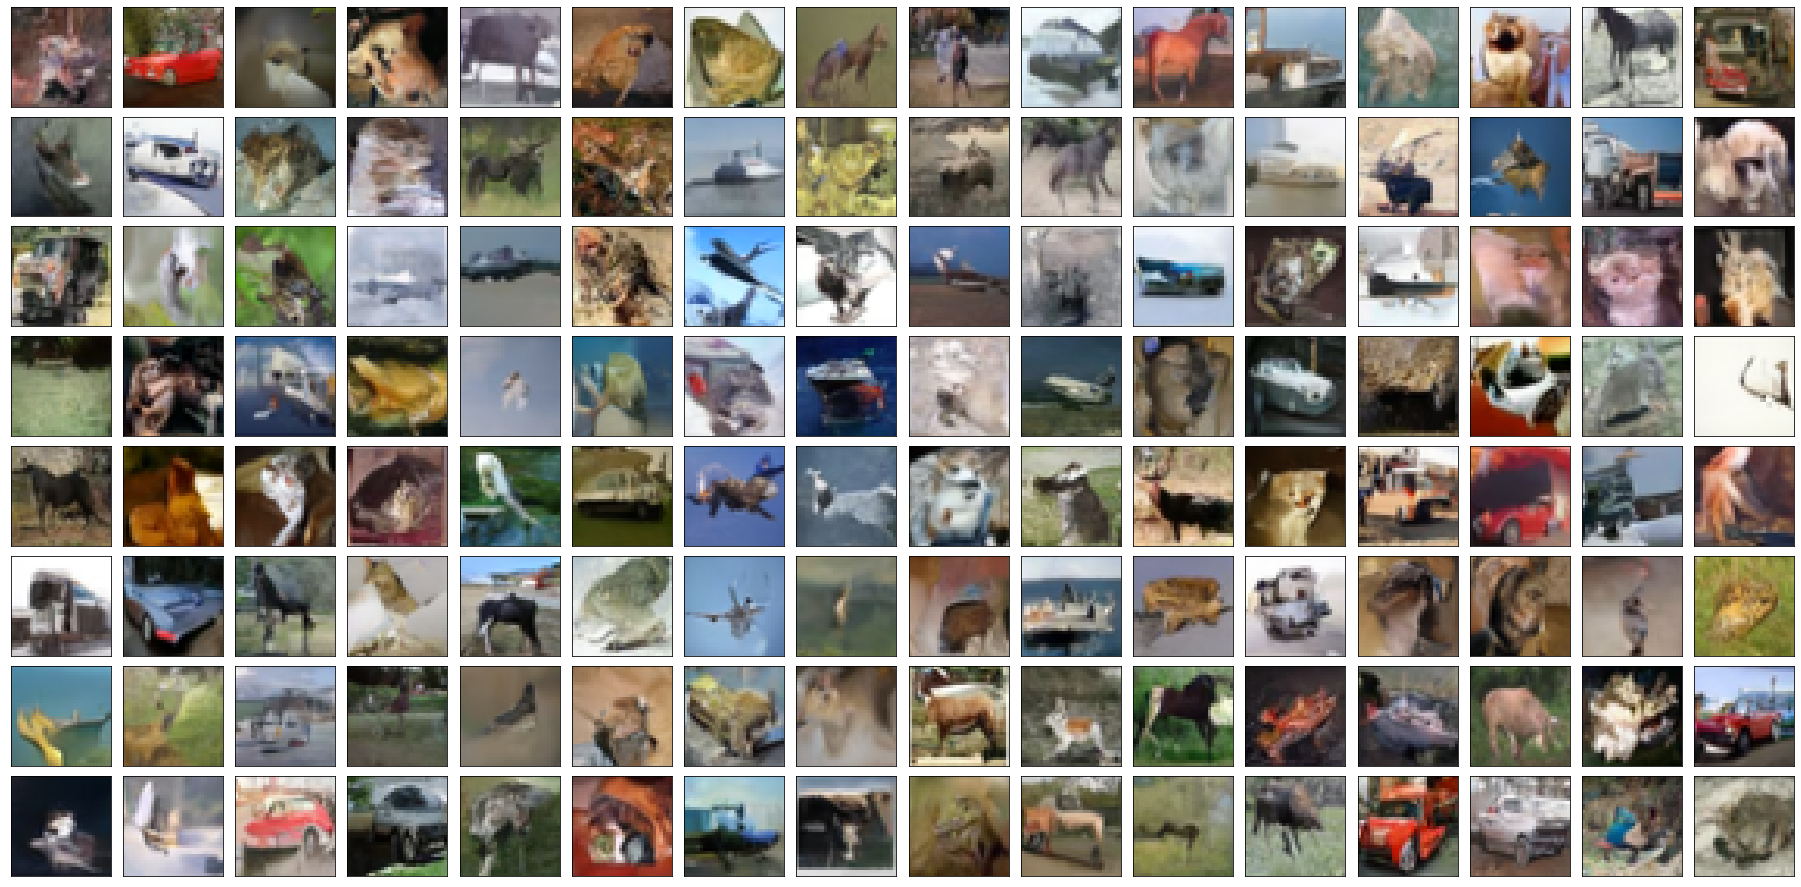

In [22]:
z = torch.randn(128, 3, 32, 32).to(args.device)
z, zloc = scheduler.reverse_process(z, ema_model, num_steps=100)

out = zloc.clamp(-1, 1).permute(0, 2, 3, 1).detach().cpu().numpy()
out = (out + 1.) * 0.5

fig = plt.figure(figsize=(32, 16))

n = 0

for i in range(8 *  16):
    _fig = fig.add_subplot(8, 16, n + 1, xticks=[], yticks=[])
    _fig.imshow(out[i])
    n += 1

plt.subplots_adjust(hspace=0.1, wspace=0.1)
plt.show()